# Empirical, anecdotal analysis of `mainnnet` mempool consistency

**<font color="red">PRELIMINARY, PARTIAL DRAFT: WORK IN PROGRESS</font>**

## Set up

In [1]:
suppressMessages({
    require(RColorBrewer, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Hourly summary

In [2]:
mempoolHourly <- fread("mempool_hourly.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolHourly) <- c("Region", "Time", "Tx first seen", "Tx count", "Tx fraction")
mempoolHourly %>% summary

            Region        Time                        Tx first seen  
 ap-northeast-1: 8   Min.   :2025-11-19 21:00:00.00   Mode :logical  
 eu-central-1  :86   1st Qu.:2025-11-20 10:00:00.00   FALSE:57       
 us-east-2     :10   Median :2025-11-20 23:00:00.00   TRUE :47       
                     Mean   :2025-11-20 23:23:39.23                  
                     3rd Qu.:2025-11-21 16:00:00.00                  
                     Max.   :2025-11-21 21:00:00.00                  
    Tx count        Tx fraction      
 Min.   :   2.00   Min.   :0.001448  
 1st Qu.:  17.75   1st Qu.:0.013006  
 Median : 756.00   Median :0.843462  
 Mean   : 769.32   Mean   :0.557692  
 3rd Qu.:1246.50   3rd Qu.:0.991326  
 Max.   :5138.00   Max.   :1.000000  

### Hourly fraction of transactions preceding the block

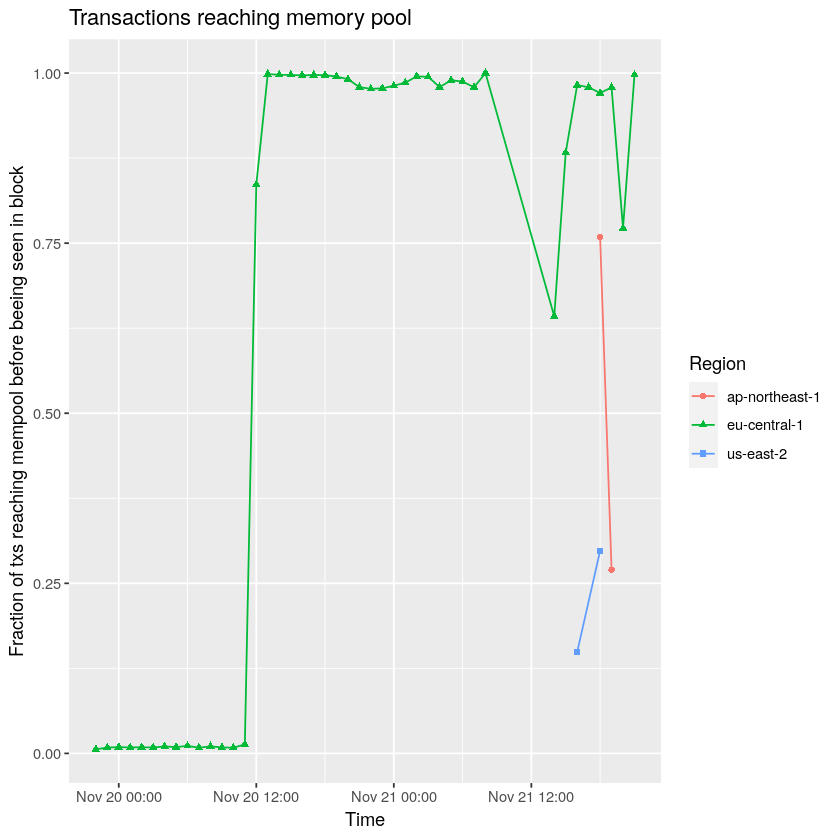

In [3]:
ggplot(mempoolHourly[`Tx first seen` == TRUE], aes(x=`Time`, y=`Tx fraction`, color=`Region`, shape=`Region`)) +
    geom_line() +
    geom_point() +
    ylab("Fraction of txs reaching mempool before beeing seen in block") +
    ggtitle(
        "Transactions reaching memory pool"
    )

In [4]:
ggsave("mempool_hourly.png", units="in", dpi=150, width=8, height=6)

## Mempool history

In [5]:
mempoolHistory <- fread("mempool_history.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolHistory) <- c("Region", "Slot", "Tx seen first", "Tx count")
mempoolHistory %>% summary

            Region          Slot           Tx seen first      Tx count    
 ap-northeast-1: 742   Min.   :172020832   Mode :logical   Min.   :  1.0  
 eu-central-1  :6463   1st Qu.:172062988   FALSE:3765      1st Qu.:  3.0  
 us-east-2     : 641   Median :172104714   TRUE :4081      Median :  7.0  
                       Mean   :172108126                   Mean   : 10.2  
                       3rd Qu.:172144052                   3rd Qu.: 14.0  
                       Max.   :172195023                   Max.   :122.0  

In [6]:
mempoolHistory[, `Tx fraction` := as.numeric(`Tx count`) / sum(`Tx count`), by =.(`Region`, `Slot`)]

### Histogram of slot-by-slot fraction of transactions preceding the block (nonlinear scale)

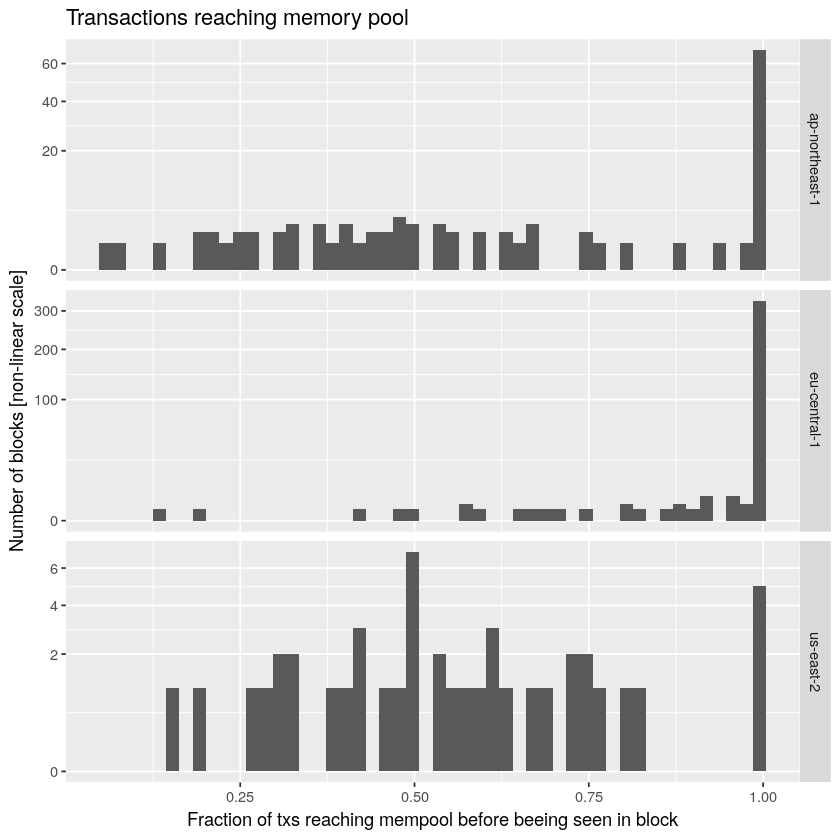

In [7]:
ggplot(mempoolHistory[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Tx fraction`)) +
    geom_histogram(bins=50) +
    scale_y_sqrt() +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks [non-linear scale]") +
    ggtitle(
        "Transactions reaching memory pool"
    )

### Histogram of slot-by-slot fraction of transactions preceding the block

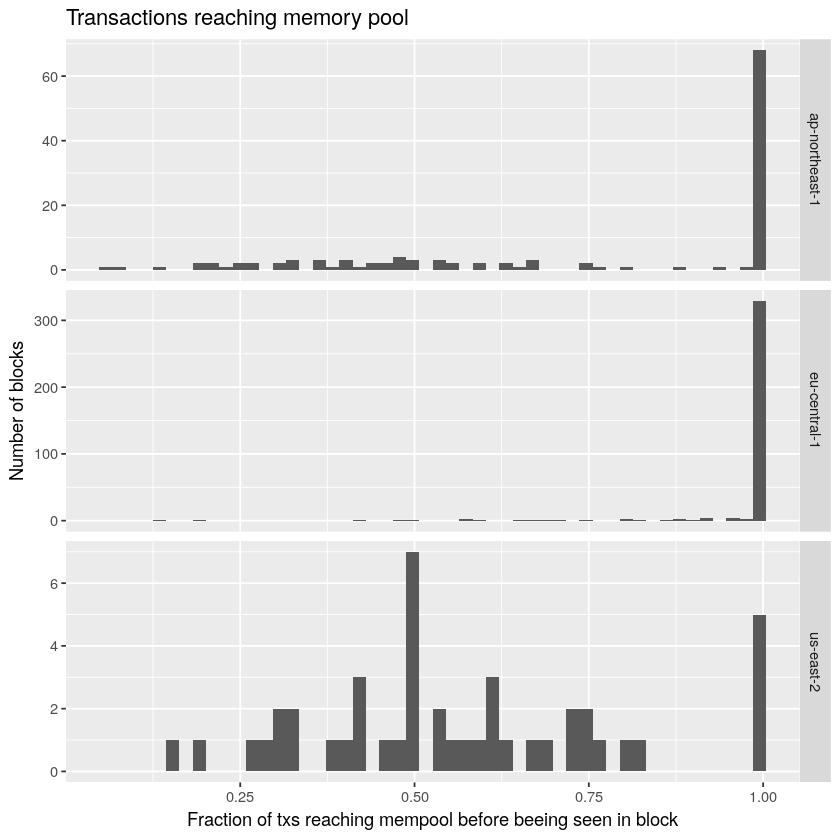

In [8]:
ggplot(mempoolHistory[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Tx fraction`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Fraction of txs reaching mempool before beeing seen in block") +
    ylab("Number of blocks") +
    ggtitle(
        "Transactions reaching memory pool"
    )

In [9]:
ggsave("mempool_history.png", units="in", dpi=150, width=8, height=6)

## Mempool vs blocks

In [10]:
mempoolBlocks <- fread("mempool_vs_blocks.tsv.gz", stringsAsFactors=TRUE)
colnames(mempoolBlocks) <- c("Region", "Slot", "Block hash", "Tx hash", "Tx hash8", "Slot time", "Block logged", "Tx logged", "Mempool - slot time [s]", "Block - slot time [s]", "Tx seen first")
mempoolBlocks %>% summary

            Region           Slot          
 ap-northeast-1:10348   Min.   :172020832  
 eu-central-1  :60190   1st Qu.:172083280  
 us-east-2     : 9471   Median :172121653  
                        Mean   :172120762  
                        3rd Qu.:172173762  
                        Max.   :172195023  
                                           
                                                            Block hash   
 4b9b817fb2ebd0959b7d31decc8225f6c4de874c2359706c327753c3961f4cc9:  237  
 90ab0197e16e39cf5af31bd1d193151f3582a2bee468ea953987e4b1c59de280:  224  
 b04ba46586aef364000ee0e42fa5fba6cdfae2294950e1ffb6c7fa2059fb7460:  222  
 ad8c59a6ae59ad5c49071cd49a8a21944555cbdbc695d9c47c4081bbb78fe78a:  183  
 fb40a3b7b7345173b8fcaa6799c653ee6c4db821407b57598cfb3cc076b59686:  177  
 10fe42ba07c542e7152d958496d767e8244556bee5725324b0aec852ff325b7f:  168  
 (Other)                                                         :78798  
                                                        

### Histogram of transaction arrival time relative to slot

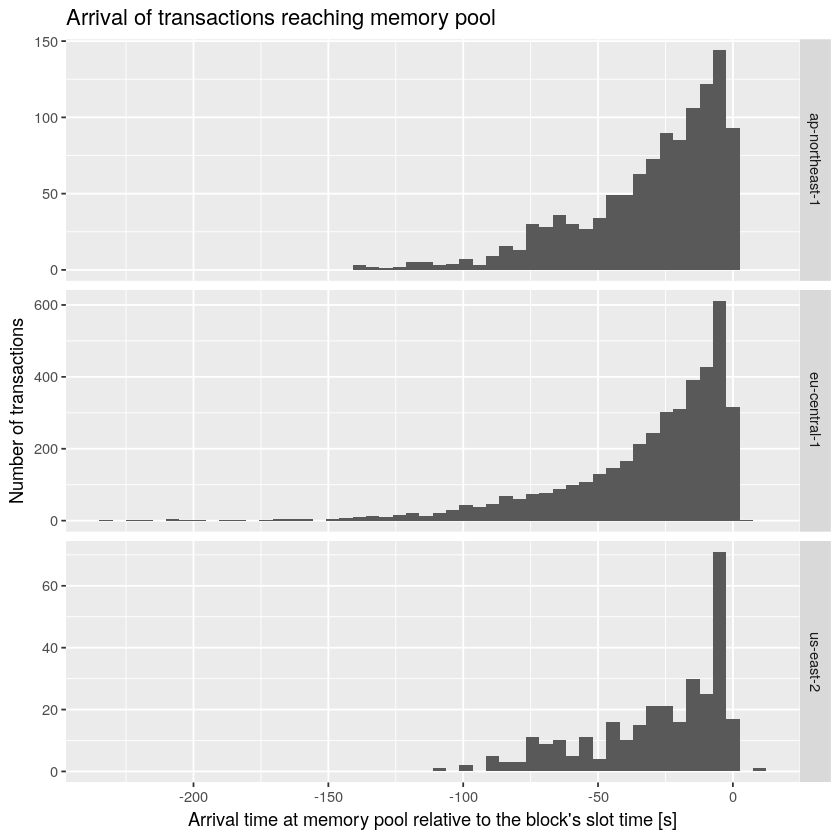

In [11]:
ggplot(mempoolBlocks[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600  & `Tx seen first` == TRUE], aes(x=`Mempool - slot time [s]`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Arrival time at memory pool relative to the block's slot time [s]") +
    ylab("Number of transactions") +
    ggtitle(
        "Arrival of transactions reaching memory pool"
    )

In [12]:
ggsave("transaction_arrival.png", units="in", dpi=150, width=8, height=6)

### Histogram of block arrival time relative to slot

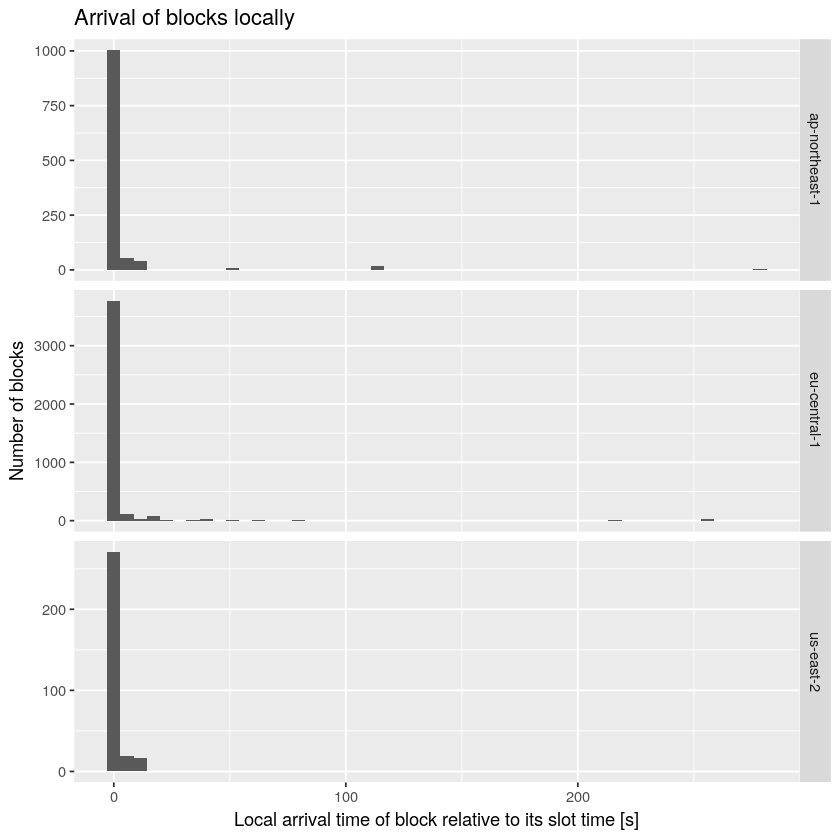

In [13]:
ggplot(mempoolBlocks[`Slot` >= mempoolHistory[, max(`Slot`)] - 4 * 3600 & `Tx seen first` == TRUE], aes(x=`Block - slot time [s]`)) +
    geom_histogram(bins=50) +
    facet_grid(`Region` ~ ., scales="free_y") +
    xlab("Local arrival time of block relative to its slot time [s]") +
    ylab("Number of blocks") +
    ggtitle(
        "Arrival of blocks locally"
    )

In [14]:
ggsave("block_arrival.png", units="in", dpi=150, width=8, height=6)